# Schelling's model of segregation

Described [here](https://en.wikipedia.org/wiki/Schelling%27s_model_of_segregation).

Implementation method [here](http://nifty.stanford.edu/2014/mccown-schelling-model-segregation/).

In [17]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random as rd

INITIAL VALUES FOR VARIABLES

In [18]:
N  = int(20)

density = 0.71  #starting percentage
f1      = 0.4  #fraction of '1' in starting population
f_1     = 1-f1 #fraction of '-1' in starting population

t  =  0.7     #percentage of neighbourhood that must be like the agent

# define color map 
color_map = {-1: np.array([255, 0, 0]), # red
             0: np.array([255, 255, 255]), # green
             1: np.array([0, 0, 255])} # blue 

In [19]:
#initialize matrix
matrix = list()

for i in range(N):
    linha = list()
    for j in range(N):
        linha.append(0)
    matrix.append(linha)       

In [20]:
#fill matrix
for linha in range(len(matrix)):
    for coluna in range(len(matrix[linha])):
        if (rd.random() <= density):
            if (rd.random() <= f1):
                matrix[linha][coluna] = 1
            else:
                matrix[linha][coluna] = -1

In [21]:
def make_matrix(N):
    matrix = list()

    for i in range(N):
        linha = list()
        for j in range(N):
            linha.append(0)
        matrix.append(linha)
        
    for linha in range(N):
        for coluna in range(N):
            if (rd.random() <= density):
                if (rd.random() <= f1):
                    matrix[linha][coluna] = 1
                else:
                    matrix[linha][coluna] = -1
    return matrix

In [22]:
offset = 1/2

def get_r (i, j, N): #i - indice linha; j - indice coluna; N - dimensão matriz
    return np.sqrt((i-(N/2 - offset))**2  +   (j-(N/2 - offset))**2)

## Tolerance Matrix

In [23]:
def get_tol_matrix(N, tmax, tmin): #Returns matrix with tolerance value for each position
    r_matrix = list()
    Rmax     = get_r(0, 0, N)
    for i in range(N):
        linha = list()
        for j in range(N):
            r = get_r(i=i, j=j, N=N)
            #################################
            tol = tmin + r*(tmax - tmin)/Rmax
            #################################
            
            linha.append(tol)
        r_matrix.append(linha)
    return r_matrix

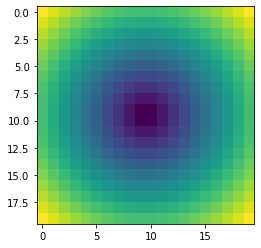

In [24]:
tol_matrix = get_tol_matrix(N, tmax=0.7, tmin=0.3)
plt.imshow(tol_matrix)

In [25]:
#min(tol_matrix)
#max(tol_matrix)

Code to manipulate color from [here](https://stackoverflow.com/questions/37719304/python-imshow-set-certain-value-to-defined-color).

In [26]:
def print_matrix(matrix, marker=False, save=False, filename=None):
    N = len(matrix)
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(1, 1, 1)
    # make a 3d numpy array that has a color channel dimension   
    data_3d = np.ndarray(shape=(N, N, 3), dtype=int)
    for i in range(0, N):
        for j in range(0, N):
            data_3d[i][j] = color_map[matrix[i][j]]
            
    if(marker):
        x = [coord[1] for coord in marker]
        y = [coord[0] for coord in marker]

        ax.scatter(x, y, color='lime', s=300/N)
    
    ax.imshow(data_3d)
    ax.set_xticks([])
    ax.set_yticks([])
    if save:
        fig.savefig(filename)
        #mpl.image.imsave(filename, data_3d)

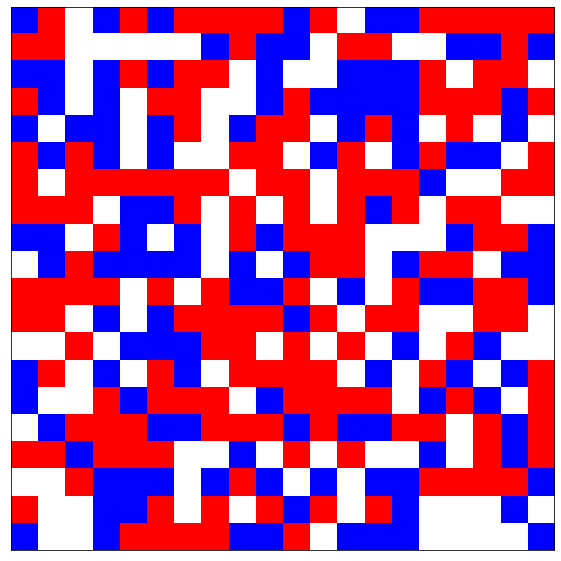

In [27]:
print_matrix(matrix)

In [28]:
def get_neighbours(coordinates, N):
    neighbours = list()
    n_range    = [-1, 0, 1]
    [x, y]     = coordinates
    
    for i in n_range:
        for j in n_range:
            
            neighbour_coords_x = coordinates[0]+i
            neighbour_coords_y = coordinates[1]+j
            
            if (neighbour_coords_x > N - 1):
                neighbour_coords_x = 0
                
            if (neighbour_coords_x < 0):
                neighbour_coords_x = N - 1
            
            if (neighbour_coords_y > N - 1):
                neighbour_coords_y = 0
                
            if (neighbour_coords_y < 0):
                neighbour_coords_y = N - 1
                
            if (not(i == 0 and j == 0)):
                neighbours.append([neighbour_coords_x, neighbour_coords_y])
            
            # getting regular/immediate neighbours
            #if ((x+i >= 0 and x+i < N) and (y+j >= 0 and y+j < N)) and (not (i == 0 and j == 0)):
            #    neighbours.append([coordinates[0]+i, coordinates[1]+j])
                  
    return neighbours

def get_empty_space(matrix):
    empty_coords = list()
    for linha in range(len(matrix)):
        for coluna in range(len(matrix)):
            if matrix[linha][coluna] == 0:
                empty_coords.append([linha, coluna])
    return empty_coords
            
def check_neighbours(coordinates, matrix):
    N = len(matrix)
    neighbours = get_neighbours(coordinates,N)
    content = list()
    
    content = [matrix[pos[0]][pos[1]] for pos in neighbours]
    
    return content

In [29]:
print(get_neighbours([0,0], N))
check_neighbours([0, 0], matrix)

[[19, 19], [19, 0], [19, 1], [0, 19], [0, 1], [1, 19], [1, 0], [1, 1]]


[1, 1, 0, -1, -1, 1, -1, -1]

We now need to find the dissatisfied agents

In [30]:
#algo return 1 if agent gathers conditions that satisfy dissatisfaction and 0 if it doesn't

# algo(coordinates, matrix)
def get_dissatisfied(matrix, algo, tol_matrix):
    dissatisfied = list()
    for linha in range(len(matrix)):
        for coluna in range(len(matrix)):
            if algo([linha, coluna], matrix, tol_matrix):
                dissatisfied.append([linha, coluna])
    return dissatisfied

In [31]:
def get_happiness(matrix, algo, tol_matrix, diss_list=None):
    if not (diss_list):
        diss_list = get_dissatisfied(matrix, algo, tol_matrix)
    return (1 - len(diss_list)/N**2)

Simple algorithm that checks if theres a minimum percentage of t neighbours around

In [32]:
def dis_algo(coord, matrix, tol_matrix):
    
    ############## t comes from the tolerance matrix
    t = tol_matrix[coord[0]][coord[1]]
    
    agent_val = matrix[coord[0]][coord[1]]
    if (agent_val):
        n_agents  = check_neighbours(coord, matrix)

        n_1 = 0
        n0  = 0
        n1  = 0

        for agent in n_agents:
            if agent == -1:
                n_1 += 1
            if agent == 0:
                n0  += 1
            if agent == 1:
                n1  += 1

        if (n_1 + n1) == 0:
            return 0

        val_sum = {-1:n_1, 0:n0, 1:n1}

        if val_sum[agent_val]/(n_1 + n1) < t:
            return 1
        return 0

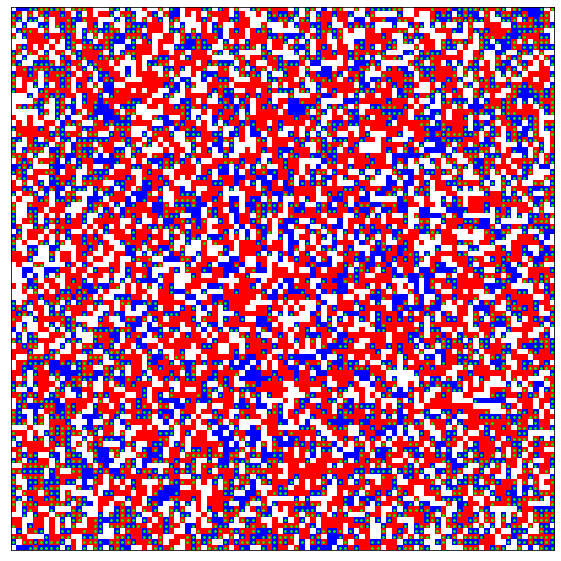

In [108]:
print_matrix(matrix, get_dissatisfied(matrix, dis_algo, tol_matrix))

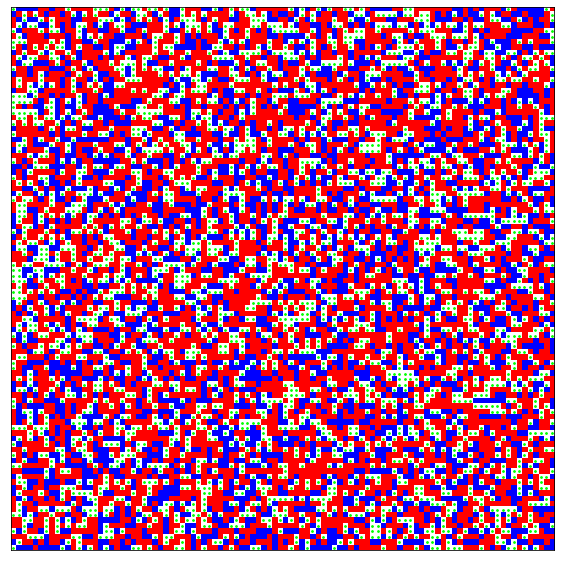

In [109]:
print_matrix(matrix, get_empty_space(matrix))

In [34]:
def iteration(matrix, algo, tol_matrix):
    new_matrix = matrix.copy()
    
    empty_space  = get_empty_space(matrix)
    dissatisfied = get_dissatisfied(matrix, algo, tol_matrix)
    
    if dissatisfied == []:
        return "STOP"
    
    for agent in dissatisfied:
        new_pos = rd.choice(empty_space) #Choosing a random empty space to be occupied by agent
        
        new_matrix[new_pos[0]][new_pos[1]] =  new_matrix[agent[0]][agent[1]]
        new_matrix[agent[0]][agent[1]] = 0
        
        empty_space.pop(empty_space.index(new_pos))
        empty_space.append(agent)
        
    return new_matrix

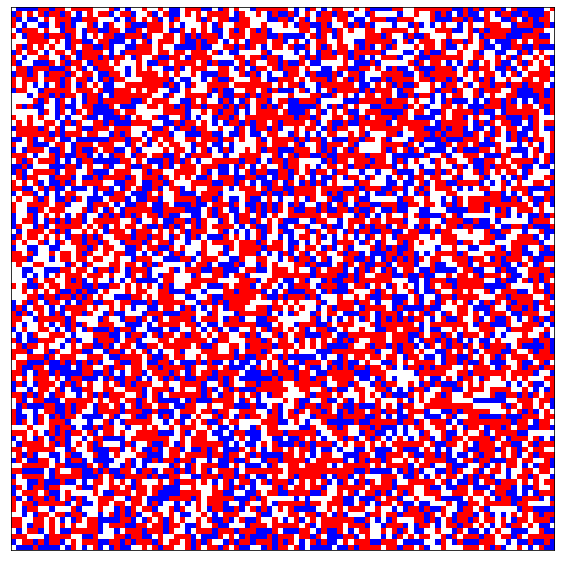

In [112]:
print_matrix(matrix)

In [56]:
N = 100
density = 0.95  #starting percentage
f1      = 0.45  #fraction of '1' in starting population
f_1     = 1-f1 #fraction of '-1' in starting population

matrix_    = make_matrix(N)
new_matrix = matrix_.copy()

tol_matrix = get_tol_matrix(N, tmax=0.9, tmin=0.1)

happiness = list()

for i in range(100):
    if i > 0:
        new_matrix = iteration(matrix_, dis_algo, tol_matrix)
    
    if new_matrix == "STOP":
        print("PAREI NO " + str(i))
        break
        
    happiness.append(get_happiness(matrix_, dis_algo, tol_matrix))
    matrix = new_matrix.copy()
    
    #print_matrix(matrix, save=True, filename='imag/iter_' + str(i) + '.png')

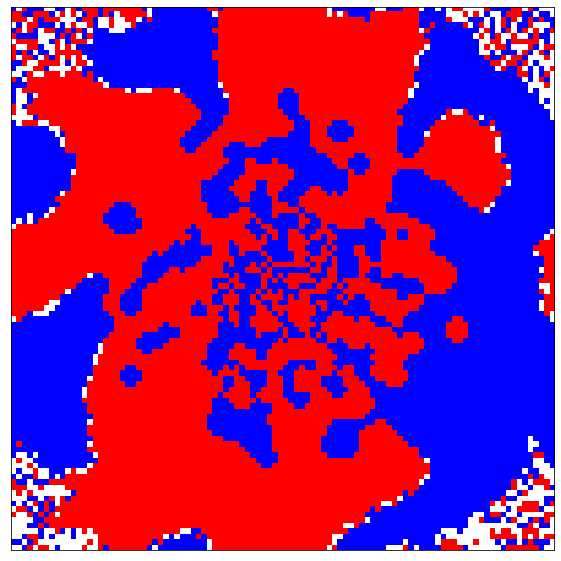

In [57]:
print_matrix(matrix)

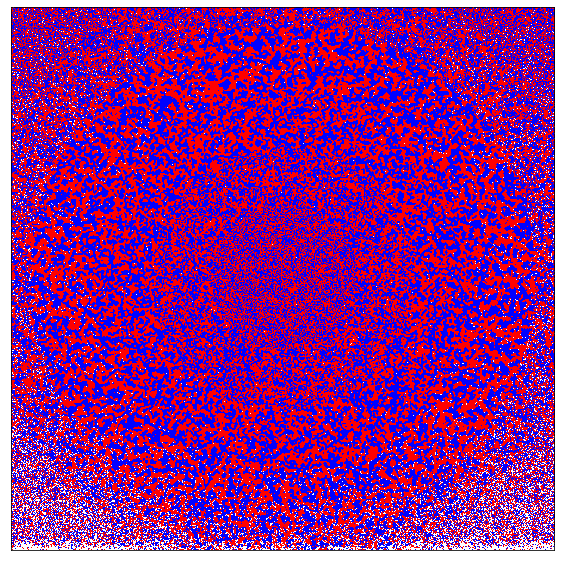

In [187]:
#print_matrix(matrix, save=True, filename='pretty.png')
print_matrix(matrix)

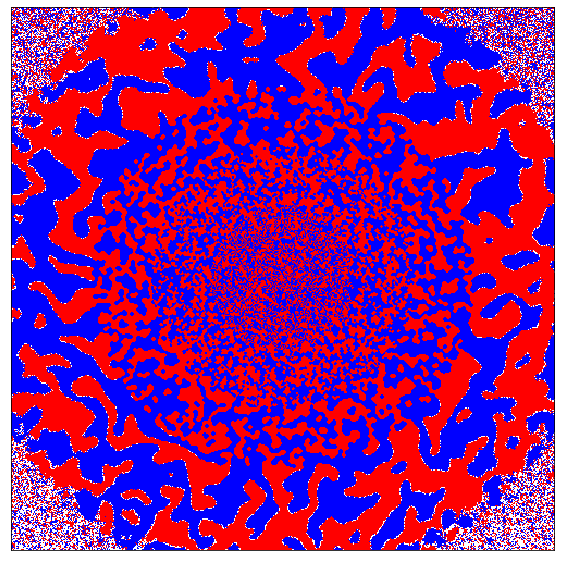

In [169]:
#print_matrix(matrix, save=True, filename='amt_.png')
#print_matrix(matrix)

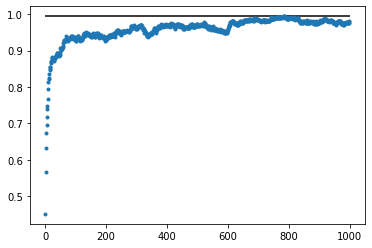

In [183]:
plt.plot(happiness, '.')
plt.hlines(max(happiness), 0, 1000)

Estou interessado em perceber a partir de que valor t, o sistema deixa de convergir

In [97]:
stopped_at = list()
t_count    = 0
for t in np.linspace(0.1, 1, 200):
    t_count += 1
    matrix     = make_matrix(50)
    new_matrix = matrix.copy()
    for i in range(300):
        if i > 0:
            new_matrix = iteration(matrix, dis_algo, t)

        if new_matrix == "STOP":
            print(str(t_count) + " - PAREI NO " + str(i))
            stopped_at.append(i)
            break

        matrix = new_matrix.copy()

        #print_matrix(matrix, save=True, filename='imag/iter_' + str(i) + '.png')

IndentationError: expected an indented block (<ipython-input-97-70ce5257b64c>, line 11)

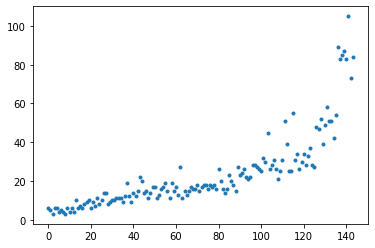

In [96]:
plt.plot(stopped_at, '.')

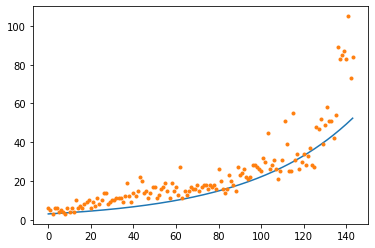

In [118]:
x = np.linspace(0, 143, 144)
plt.plot(x, 3*np.exp(x*2e-2))
plt.plot(stopped_at, '.')